# 수확량 예측

In [ ]:
'''!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf'''

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
'''import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list'''

## Machine Learning Model 만들기

2월 부터 7월 까지 0시 부터 23시 까지  
아무 시간대나 입력하면 예측 값 출력해주는 모델 생성  
매일 자정에 모델 업데이트

처음부터 끝까지 사용해서 학습  
바로 직전 조건을 토대로 다음 결과 예측  
현재 + offset 시간  
바로 다음 또는 특정 시점의 환경 예측  
지금까지의 데이터를 토대로 수학 시점까지의 데이터 만들어 내서 만든 데이터 기반으로 수확량 예측  
지금까지의 기조가 유지되면 얼만큼의 수확량이 나오는지 계산  


** 특정 시점의 데이터 예측 후 부족한 점(습도, 온도)을 파악하여 팬, 급수펌프 가동

* K-Nearest Neighbor
* Decision Tree
* Random Forest
* Naive Bayse
* SVM


### 머신러닝 패키지 호출

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import sklearn

PATH = '/content/drive/MyDrive/[2022]GraduationProject/'

warnings.filterwarnings(action='ignore')

# 한글 깨짐 방지

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic') 

#### 머신러닝 모델 패키지 호출

In [ ]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from datetime import datetime

In [ ]:
file_name = 'yield.csv'
url = PATH + file_name

In [ ]:
origin_data = pd.read_csv(url)
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   조사일         432 non-null    object 
 1   주차          408 non-null    object 
 2   초장          432 non-null    float64
 3   엽장          384 non-null    float64
 4   엽폭          384 non-null    float64
 5   엽병장         408 non-null    float64
 6   엽수          312 non-null    float64
 7   관부직경        408 non-null    float64
 8   화방 꽃수(소화수)  216 non-null    float64
 9   착과수         336 non-null    float64
 10  최종화방차수      240 non-null    float64
dtypes: float64(9), object(2)
memory usage: 37.2+ KB


In [ ]:
origin_data.head()

,조사일,주차,초장,엽장,엽폭,엽병장,엽수,관부직경,화방 꽃수(소화수),착과수,최종화방차수
0,2021-01-28,21주차,32.0,7.0,6.0,21.0,9.0,20.0,1.0,2.0,2.0
1,2021-01-28,21주차,32.0,7.0,6.0,21.0,9.0,20.0,1.0,2.0,2.0
2,2021-01-28,21주차,32.0,7.0,6.0,21.0,9.0,20.0,1.0,2.0,2.0
3,2021-01-28,21주차,32.0,7.0,6.0,21.0,9.0,20.0,1.0,2.0,2.0
4,2021-01-28,21주차,32.0,7.0,6.0,21.0,9.0,20.0,1.0,2.0,2.0


In [ ]:
origin_data = origin_data.drop(['조사일', '주차'], axis=1)
origin_data = origin_data.fillna(0)
origin_data.describe()

,초장,엽장,엽폭,엽병장,엽수,관부직경,화방 꽃수(소화수),착과수,최종화방차수
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,32.055556,7.166667,6.333333,14.944444,7.444444,21.666667,0.777778,2.777778,2.388889
std,2.918326,2.816919,2.519529,5.022147,4.769068,5.483576,1.031597,2.349244,2.339347
min,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,7.000000,6.000000,12.000000,0.000000,21.000000,0.000000,0.000000,0.000000
50%,32.000000,7.500000,6.500000,15.000000,9.500000,23.000000,0.000000,2.500000,2.500000
75%,33.000000,9.000000,8.000000,18.000000,11.000000,25.000000,1.000000,5.000000,5.000000
max,38.000000,11.000000,10.000000,22.000000,13.000000,25.000000,3.000000,6.000000,6.000000


In [ ]:
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   초장          432 non-null    float64
 1   엽장          432 non-null    float64
 2   엽폭          432 non-null    float64
 3   엽병장         432 non-null    float64
 4   엽수          432 non-null    float64
 5   관부직경        432 non-null    float64
 6   화방 꽃수(소화수)  432 non-null    float64
 7   착과수         432 non-null    float64
 8   최종화방차수      432 non-null    float64
dtypes: float64(9)
memory usage: 30.5 KB


In [ ]:
df_date = origin_data.groupby('착과수').mean()
df_date

,초장,엽장,엽폭,엽병장,엽수,관부직경,화방 꽃수(소화수),최종화방차수
착과수,,,,,,,,
0.0,33.6,5.80,6.80,18.2,7.00,24.0,0.6,4.20
1.0,32.0,9.00,4.00,8.5,6.00,25.0,0.0,5.00
2.0,32.0,7.00,6.00,19.0,9.00,20.5,1.5,1.00
3.0,31.0,8.00,7.00,15.0,9.00,22.5,0.5,0.00
4.0,38.0,9.00,7.00,20.0,10.00,0.0,2.0,0.00
5.0,29.5,7.00,7.00,12.5,5.00,23.0,0.5,1.50
6.0,30.5,7.25,6.25,12.0,7.75,22.0,1.0,1.75


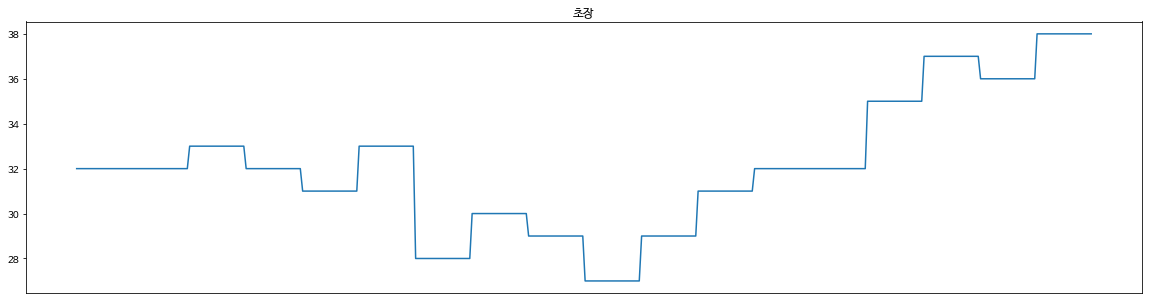

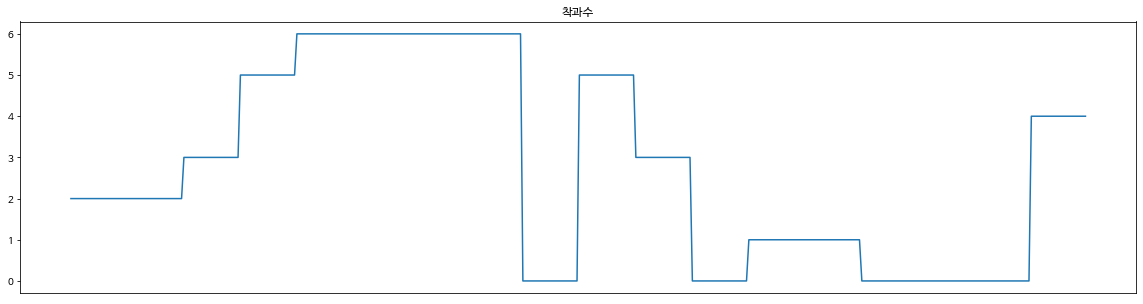

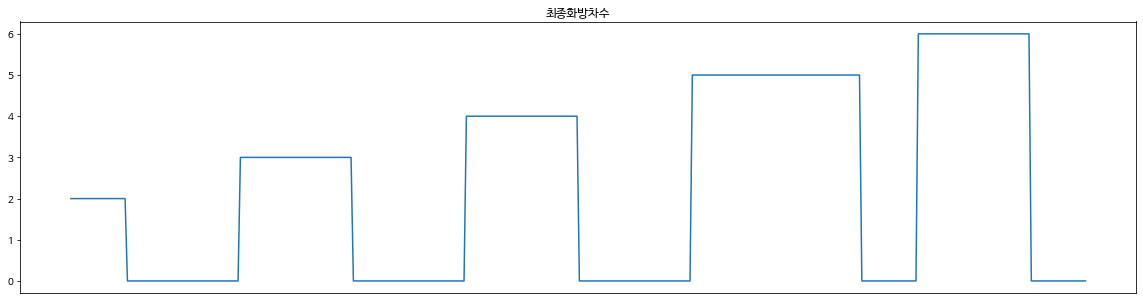

In [ ]:
x = origin_data.index.values
cols = ['초장', '착과수', '최종화방차수']

for col in cols:
    plt.figure(figsize=(20, 5))
    plt.title(col)
    plt.plot(x, origin_data[col])
    plt.gca().axes.xaxis.set_visible(False)
    plt.show()

### Score 저장할 DF 생성

In [ ]:
models = ['KNN', 'Decision Tree', 'Random Forest', 'Naive Bayse', 'SVM']
modelLength = len(models)

In [ ]:
yield_predict = pd.DataFrame({'model':['KNN', 'Decision Tree', 'Random Forest', 'Naive Bayse', 'SVM'],
                           'CV_mean':[0 for i in range(modelLength)],
                           'best param':[0 for i in range(modelLength)],
                           'predict':[0 for i in range(modelLength)],
                           'recommended':[0 for i in range(modelLength)]})
yield_predict

,model,CV_mean,best param,predict,recommended
0,KNN,0,0,0,0
1,Decision Tree,0,0,0,0
2,Random Forest,0,0,0,0
3,Naive Bayse,0,0,0,0
4,SVM,0,0,0,0


In [ ]:
y = origin_data['착과수']
x = origin_data.drop(['착과수'], axis=1)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=30, test_size=0.1)

In [ ]:
x.loc[0]

초장            32.0
엽장             7.0
엽폭             6.0
엽병장           21.0
엽수             9.0
관부직경          20.0
화방 꽃수(소화수)     1.0
최종화방차수         2.0
Name: 0, dtype: float64

### KNN

In [ ]:
max_score = 0
max_k = 0
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(x_train, y_train)
    score = knn.score(x_valid, y_valid)
    if max_score < score :
        max_score = score
        max_k = k
    print('k: %d, accuracy: %.2f' % (k, score*100))

print('best case')
print('k: %d, accuracy: %.2f' % (max_k, max_score*100))

k: 1, accuracy: 100.00
k: 2, accuracy: 100.00
k: 3, accuracy: 100.00
k: 4, accuracy: 100.00
k: 5, accuracy: 100.00
k: 6, accuracy: 100.00
k: 7, accuracy: 100.00
k: 8, accuracy: 100.00
k: 9, accuracy: 100.00
k: 10, accuracy: 100.00
best case
k: 1, accuracy: 100.00


In [ ]:
knn = KNeighborsClassifier(n_neighbors=max_k, n_jobs=-1)
knn.fit(x_train, y_train)
max_score = knn.score(x_valid, y_valid)
predict_value = knn.predict(x.iloc[-1].to_numpy().reshape(1, -1))[0]

yield_predict['CV_mean'][yield_predict['model'] == 'KNN'] = max_score
yield_predict['best param'][yield_predict['model'] == 'KNN'] = max_k
yield_predict['predict'][yield_predict['model'] == 'KNN'] = predict_value

### Decision Tree

In [ ]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
model.fit(x_train, y_train)

y_pred_tr = model.predict(x_valid)
print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred_tr))
accuracy = accuracy_score(y_valid, y_pred_tr)
predict_value = model.predict(x.iloc[-1].to_numpy().reshape(1, -1))[0]

yield_predict['CV_mean'][yield_predict['model'] == 'Decision Tree'] = accuracy
yield_predict['predict'][yield_predict['model'] == 'Decision Tree'] = predict_value

Accuracy: 0.82


### Random Forest

estimators 숫자 바꾸면서 7이 아닌 다른 최적의 경우 찾기

In [ ]:
model = RandomForestClassifier(n_estimators=7, random_state=0, oob_score=True)
model.fit(x_train, y_train)

train_accuracy = model.score(x_train, y_train)
test_accuracy = model.score(x_valid, y_valid)
oob_accuracy = model.oob_score_

caseList = ['test', 'oob']
accuracy = [test_accuracy, oob_accuracy]
best_acc = 0
best_case = ''

for i in range(2):
    if best_acc < accuracy[i]:
        best_acc = accuracy[i]
        best_case = caseList[i]


print('Case : train, Accuracy: %.2f' % train_accuracy)
print('Case : test, Accuracy: %.2f' % test_accuracy)
print('Case : oob, Accuracy: %.2f' % oob_accuracy)
predict_value = model.predict(x.iloc[-1].to_numpy().reshape(1, -1))[0]

yield_predict['CV_mean'][yield_predict['model'] == 'Random Forest'] = best_acc
yield_predict['best param'][yield_predict['model'] == 'Random Forest'] = best_case
yield_predict['predict'][yield_predict['model'] == 'Random Forest'] = predict_value

Case : train, Accuracy: 1.00
Case : test, Accuracy: 1.00
Case : oob, Accuracy: 0.97


### Naive Bayse

In [ ]:
model = GaussianNB()
model.fit(x_train, y_train)

accuracy = model.score(x_valid, y_valid)
print ("Accuracy: ", accuracy)
predict_value = model.predict(x.iloc[-1].to_numpy().reshape(1, -1))[0]

yield_predict['CV_mean'][yield_predict['model'] == 'Naive Bayse'] = accuracy
yield_predict['predict'][yield_predict['model'] == 'Naive Bayse'] = predict_value

Accuracy:  0.7954545454545454


### SVM

In [ ]:
find_grid = SVC(kernel = 'rbf',random_state=100)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(find_grid,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train, y_train)
predict_value = model.predict(x.iloc[-1].to_numpy().reshape(1, -1))[0]

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
svm_result = result.sort_values(by='mean_test_score', ascending=False)
svm_result

,C,gamma,mean_test_score
63,100.000,100.000,1.000000
44,25.000,10.000,1.000000
46,25.000,50.000,1.000000
45,25.000,25.000,1.000000
26,1.000,0.100,1.000000
...,...,...,...
12,0.010,10.000,0.280919
13,0.010,25.000,0.280919
14,0.010,50.000,0.280919
15,0.010,100.000,0.280919


In [ ]:
svm_best_params = '{C:' + str(svm_result.iloc[0,0]) + '}, {gamma:'+ str(svm_result.iloc[0,1]) +'}'
yield_predict['CV_mean'][yield_predict['model'] == 'SVM'] = svm_result.iloc[0,2]
yield_predict['best param'][yield_predict['model'] == 'SVM'] = svm_best_params
yield_predict['predict'][yield_predict['model'] == 'SVM'] = predict_value

### Recommend Model

In [ ]:
models = ['KNN', 'Decision Tree', 'Random Forest', 'Naive Bayse', 'SVM']
modelLength = len(models)

In [ ]:
best_model = ''
max_acc = 0

for model in models:
    acc = yield_predict['CV_mean'][yield_predict['model'] == model].values[0]
    if acc > max_acc:
        max_acc = acc
        best_model = model

print('best_model : ', best_model, '\nmax_acc : ', max_acc)
yield_predict['recommended'][yield_predict['model'] == best_model] = 1.0

best_model :  KNN 
max_acc :  1.0


### Results

In [ ]:
yield_predict

,model,CV_mean,best param,predict,recommended
0,KNN,1.000000,1,4,1
1,Decision Tree,0.818182,0,4,0
2,Random Forest,1.000000,test,4,0
3,Naive Bayse,0.795455,0,4,0
4,SVM,1.000000,"{C:100.0}, {gamma:100.0}",4,0


In [ ]:
yield_predict.to_csv("yield_predict.csv", index = False)